In [85]:
##This code is for 1 Hz n s files. For 1 Hz 1s files, use 20200818 code, where fitting works

In [86]:
# import stuff
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy
from scipy import signal
import h5py, time
from iminuit import Minuit, describe
from pprint import pprint # we use this to pretty print some stuff later

import sys
sys.path.append('/home/analysis_user/New_trap_code/Tools/')
import BeadDataFile
from discharge_tools import load_dir

In [87]:
# calibration of the voltage - position conversion
def voltage_to_position(voltage,slope=0.019834000085488412,offset=-0.0015000315197539749,redo=False):
    if(redo==True):
        pos_list=np.asarray([-0.007,4.968,9.91])
        y_err=np.asarray([0.01,0.01,0.01])
        val = np.asarray([0,250,500])
        data_x=val
        data_y=pos_list
        data_y_error=y_err
        m2=Minuit(chisquare_linear, 
             a = 100,
             b=0,
             errordef = 1,
             print_level=1)
        m2.migrad()
        print(m2.values["a"],m2.values["b"])
        plt.plot(val,pos_list,marker="*")
        plt.plot(val,m2.values["a"]*val+m2.values["b"])
        slope = m2.values["a"]
        offset = m2.values["b"]
    position=(voltage-offset)/slope
    return position

In [88]:
from scipy.optimize import curve_fit
from scipy.stats import norm

In [89]:
# load the data
Year = "2020"
Month = "10"
Day = "14"
BeadNumber = 1
#RunNumber = 144
#folder =  r"/home/data_transfer/data_from_windows/" + Year + Month + Day + "/Bead"+str(BeadNumber)+"/Shaking/"
#folder =  r"/home/data_transfer/data_from_windows/" + Year + Month + Day + "/Bead"+str(BeadNumber)+"/BeamProfile/"
folder =  r"/home/data_transfer/data_from_windows/" + Year + Month + Day + "/NoBead/BeamProfile/"
#folder =  r"/data/new_trap/" + Year + Month + Day + "/Bead1/Shaking/BeamProfile/"

In [98]:
Fname="BeamProfileX4"
files = load_dir(folder, file_prefix = Fname, max_file=500)

100%|██████████| 101/101 [00:04<00:00, 27.19it/s]

101  files in folder
101  files loaded


In [99]:
def get_waist(pos,pd, flip=False):

    pos1 = voltage_to_position(pos)
    if (flip):
        pos1 *= -1
    data1 = np.array(pd)-np.min(pd)
    data1 = data1/np.max(data1)    
    #noraml CDF fit
    temp_params = curve_fit(norm.cdf, pos1, data1, p0=[pos1[2500],5])[0]
    
    if (flip):
        temp_params[0] *= -1
    return temp_params

In [100]:
parX1 = []
parX2 = []
spin=np.zeros(5000)
j=0
for ff in files:
    pos_x = ff.cant_pos[0]
    quad_sum = ff.quad_sum
    spintemp = ff.spin_data[0]
    for i in range(0,5000):
        spin[i]=np.average(spintemp[10*i:10*i+9])
    parX1.append(get_waist(pos_x, quad_sum, flip=True))
    parX2.append(get_waist(pos_x, spin))
    
    if (j%10)==0:
        ofname = folder+"/" + Fname + "_Output_%d.txt" % j

        f1 = open(ofname,"a")
        for i in range(0,5000):
            f1.write('%f %e %e\n' % (pos_x[i], quad_sum[i], spin[i]))
        f1.close()
        print(j)
    j=j+1
    
    
parX1 = np.array(parX1)
parX2 = np.array(parX2)
ZrangeX = np.array([np.mean(ff.cant_pos[2])*10 for ff in files])

0
10
20
30
40
50
60
70
80
90
100


In [101]:
parX1 = []
parX2 = []
spin=np.zeros(5000)
j=0
for ff in files:
    pos_x = ff.cant_pos[0]
    quad_sum = ff.quad_sum
    spintemp = ff.spin_data[0]
    for i in range(0,5000):
        spin[i]=np.average(spintemp[10*i:10*i+9])
    parX1.append(get_waist(pos_x, quad_sum, flip=True))
    parX2.append(get_waist(pos_x, spin))
    
#    if (j%10)==0:
    ofname = folder+"/" + Fname + "_Output100_%d.txt" % j

    f1 = open(ofname,"a")
    for i in range(0,5000):
        f1.write('%f %e %e\n' % (pos_x[i], quad_sum[i], spin[i]))
    f1.close()
    print(j)
    j=j+1
    
    
parX1 = np.array(parX1)
parX2 = np.array(parX2)
ZrangeX = np.array([np.mean(ff.cant_pos[2])*10 for ff in files])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [62]:
def beamwidth_fun(t,z,w):
    return w*np.sqrt(1+((t-z)/np.pi/w/w*1.064)**2)

Zrange = np.linspace(5,95,91)

def fit_waist(pars):
    return curve_fit(beamwidth_fun, Zrange, pars[:,1],p0=[50,5])[0]

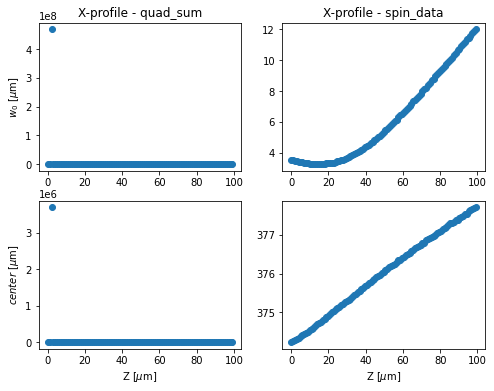

In [63]:
#draw single dataset
_, ax = plt.subplots(2,2,figsize=(8,6))

ax[0,0].scatter(ZrangeX,parX1[:,1]*2)
#ax[0,0].plot(Zrange,beamwidth_fun(Zrange,*pfitX1),'r--')
ax[0,0].set(title='X-profile - quad_sum', ylabel='$w_{0}$ [$\mu$m]')
ax[0,1].scatter(ZrangeX,parX2[:,1]*2)
#ax[0,1].plot(Zrange,beamwidth_fun(Zrange,*pfitX2),'r--')
ax[0,1].set(title='X-profile - spin_data')

ax[1,0].scatter(ZrangeX,parX1[:,0])
ax[1,0].set(xlabel='Z [$\mu$m]', ylabel='$center$ [$\mu$m]')
ax[1,1].scatter(ZrangeX,parX2[:,0])
ax[1,1].set(xlabel='Z [$\mu$m]')
ofname = folder + Fname + "_Plot.png" 

plt.savefig(ofname,dpi=300)

In [64]:
print(np.min(parX2[:,1])*2)
print(parX2[:,1]*2)
print(parX2[:,0])

3.256670608111782
[ 3.51686895  3.49575529  3.471065    3.44489852  3.41905993  3.36554141
  3.37173745  3.34496552  3.32354102  3.33512456  3.29605728  3.29386548
  3.28990424  3.27667241  3.25667061  3.27275338  3.26644813  3.26622662
  3.28606322  3.302033    3.30039969  3.3133886   3.33253324  3.35983497
  3.38729309  3.45075399  3.47285491  3.51305426  3.54169496  3.59947901
  3.6590792   3.73521392  3.79502597  3.83774737  3.91166575  3.96391909
  4.02844042  4.12077631  4.1913294   4.25830046  4.35065289  4.4243388
  4.52075562  4.61662112  4.71272181  4.80217005  4.90874813  5.01577342
  5.11177747  5.22391374  5.34374925  5.4560936   5.56704323  5.6582816
  5.79455646  5.9024541   6.04208026  6.13922906  6.28916082  6.4448019
  6.51685454  6.6503418   6.77780495  6.92779145  7.04415796  7.17380056
  7.32620661  7.4100465   7.55933821  7.68381126  7.81693102  7.97433197
  8.16334399  8.2293809   8.3656804   8.55024479  8.70224867  8.79068597
  8.96371621  9.08601974  9.21695626

In [31]:
parX2[90,0]-parX2[0,0]

3.1322796226480705

In [32]:
np.average(parX2[:,0])

328.0802731039483

In [111]:
## plot y direction

In [92]:
Fname="BeamProfileY2"
files = load_dir(folder, file_prefix = Fname, max_file=500)

100%|██████████| 101/101 [00:02<00:00, 40.94it/s]

101  files in folder
101  files loaded


In [66]:
parY1 = []
parY2 = []
spin=np.zeros(5000)
j=0
for ff in files:
    pos_y = ff.cant_pos[1]
    quad_sum = ff.quad_sum
    spintemp = ff.spin_data[0]
    for i in range(0,5000):
        spin[i]=np.average(spintemp[10*i:10*i+9])
    parY1.append(get_waist(pos_y, quad_sum))
    parY2.append(get_waist(pos_y, spin, flip=True))
    
    if (j%10)==0:
        ofname = folder+"/" + Fname + "_Output_%d.txt" % j

        f1 = open(ofname,"a")
        for i in range(0,5000):
            f1.write('%f %e %e\n' % (pos_y[i], quad_sum[i], spin[i]))
        f1.close()
        print(j)
    j=j+1
    
parY1 = np.array(parY1)
parY2 = np.array(parY2)
ZrangeY = np.array([np.mean(ff.cant_pos[2])*10 for ff in files])

0
10
20
30
40
50
60
70
80
90
100


In [93]:
parY1 = []
parY2 = []
spin=np.zeros(5000)
j=0
for ff in files:
    pos_y = ff.cant_pos[1]
    quad_sum = ff.quad_sum
    spintemp = ff.spin_data[0]
    for i in range(0,5000):
        spin[i]=np.average(spintemp[10*i:10*i+9])
    parY1.append(get_waist(pos_y, quad_sum))
    parY2.append(get_waist(pos_y, spin, flip=True))
    
#    if (j%10)==0:
    ofname = folder+"/" + Fname + "_Output100_%d.txt" % j

    f1 = open(ofname,"a")
    for i in range(0,5000):
        f1.write('%f %e %e\n' % (pos_y[i], quad_sum[i], spin[i]))
    f1.close()
    print(j)
    j=j+1
    
parY1 = np.array(parY1)
parY2 = np.array(parY2)
ZrangeY = np.array([np.mean(ff.cant_pos[2])*10 for ff in files])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


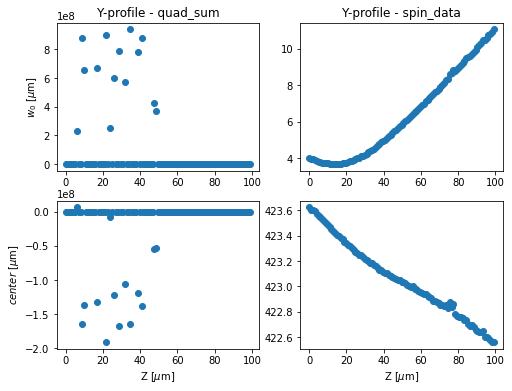

In [67]:
#draw single dataset
_, ax = plt.subplots(2,2,figsize=(8,6))

ax[0,0].scatter(ZrangeY,parY1[:,1]*2)
#ax[0,0].plot(Zrange,beamwidth_fun(Zrange,*pfitX1),'r--')
ax[0,0].set(title='Y-profile - quad_sum', ylabel='$w_{0}$ [$\mu$m]')
ax[0,1].scatter(ZrangeY,parY2[:,1]*2)
#ax[0,1].plot(Zrange,beamwidth_fun(Zrange,*pfitX2),'r--')
ax[0,1].set(title='Y-profile - spin_data')

ax[1,0].scatter(ZrangeY,parY1[:,0])
ax[1,0].set(xlabel='Z [$\mu$m]', ylabel='$center$ [$\mu$m]')
ax[1,1].scatter(ZrangeY,parY2[:,0])
ax[1,1].set(xlabel='Z [$\mu$m]')
ofname = folder + Fname + "_Plot.png" 
plt.savefig(ofname,dpi=300)

In [68]:
print(np.min(parY2[:,1])*2)
print(parY2[:,1]*2)
print(parY2[:,0])

3.684207024254775
[ 4.01449071  3.9654338   3.94916656  3.9032632   3.85243545  3.80351117
  3.79000126  3.76495367  3.75877558  3.73233376  3.72314028  3.69786312
  3.69276066  3.68787777  3.68606142  3.70179519  3.68420702  3.70485046
  3.72448741  3.7466035   3.77240177  3.79375829  3.83586359  3.87237311
  3.90181755  3.95199513  4.00436891  4.02950365  4.11551133  4.14426617
  4.20510069  4.26337357  4.33561781  4.40198592  4.48177746  4.53380201
  4.623517    4.70596075  4.78109993  4.87714801  4.95076477  5.0267202
  5.11295808  5.2067177   5.29780798  5.39260448  5.4922612   5.55120938
  5.64922601  5.75918035  5.84525591  5.94043353  6.04720827  6.12773697
  6.2197872   6.29775421  6.41460367  6.52507433  6.59138916  6.70685861
  6.80546411  6.90530183  7.00179028  7.11536312  7.18919053  7.29507825
  7.40271177  7.50680822  7.62609676  7.70766041  7.80575463  7.89595936
  8.01197862  8.13649609  8.26783816  8.35557765  8.62956954  8.66540729
  8.82523002  8.76898929  8.867334

In [48]:
def beamwidth_fun(t,z,w):
    return w*np.sqrt(1+((t-z)/np.pi/w/w*1.064)**2)

Zrange = np.linspace(5,95,91)

def fit_waist(pars):
    return curve_fit(beamwidth_fun, Zrange, pars[:,1],p0=[50,5])[0]

In [24]:
parY2[90,0]-parY2[0,0]

-1.4028983047234647

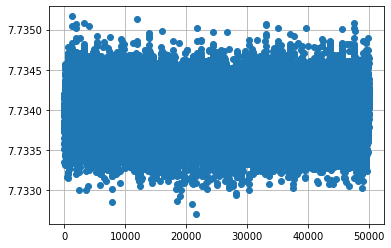

In [18]:
# plot the in-phase response
plt.plot(pos_x,linestyle="",marker="o")
#plt.ylim(-10,1)
#plt.xlim(180,270)
plt.grid(True)
plt.show()